# **NLP for topic modelling of customer reviews**

### **Business context**

The Star Gym Group focus on the customer is centred on wanting to understand what motivates members to join and what factors influence their behaviours once they have joined. Understanding how to leverage innovative technology to influence, improve, and simplify their experience allows Star Gym to foster an open, welcoming, and diverse environment for its members.

### **Objective**

Develop automated topic modeling tools to identify and understand key themes and patterns within large volumes of review data, uncovering key drivers that provide actionable insights for improving the customer experience.

### **Data**
Two datasets of customer reviews (Google and Trustpilot) are analysed. I will focus on negative reviews (ratings below 3) to identify key pain points.

###🔍**Final considerations**
Using a combination of NLP techniques like BERTopic, LLM, and LDA provides a well-rounded approach to analysing customer reviews. This integrated approach ensures deeper insights, greater accuracy, and reliable recommendations to address customer concerns effectively.

In [ ]:
!pip install umap-learn
!pip install bertopic
!pip install tensorflow

import gdown
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import random

from bertopic import BERTopic

import tensorflow as tf
from hdbscan import HDBSCAN
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import plotly.io as pio
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from gensim.models import LdaModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import string
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

###**Importing dataframes**

In [ ]:
download_url_g = pd.read_csv('/content/Google_CLEAN.csv')
download_url_t = pd.read_csv('/content/Trustpilot_CLEAN.csv')

df_google=download_url_g.copy()
trustpilot_data=download_url_t.copy()

#**1) Conducting initial data investigation**

💡 Keeping only relevant variables for the analysis and standardising columns names between datasets: Location, Comment, Score.

**Google file**

In [ ]:
columns_to_remove = [
    'Customer Name',
    'SurveyID for external use (e.g. tech support)',
    'Social Media Source',
]
df_google = df_google.drop(columns=columns_to_remove)

**Trustpilot file**

In [ ]:
columns_to_remove = [
    'Review ID',
    'Review Consumer User ID',
    'Source Of Review',
    'Review Language',
    'Domain URL',
    'Webshop Name',
    'Business Unit ID',
    'Tags',
    'Location ID'
]
df_trustpilot = df_trustpilot.drop(columns=columns_to_remove)

In [ ]:
# Standardising columns names across datasets
df_google = df_google.rename(columns={
    "Club's Name": "Location",
    "Comment": "Comment",
    "Overall Score": "Score"
})

df_trustpilot = df_trustpilot.rename(columns={
    "Location Name": "Location",
    "Review Content": "Comment",
    "Review Stars": "Score"
})

###**Remove missing values from comment columns**

In [ ]:
g_missing_values = df_google.isna().sum()
t_missing_values = df_trustpilot.isna().sum()

print(g_missing_values)
print(t_missing_values)

Location            0
Creation Date       0
Comment          9352
Score               0
dtype: int64
Review Created (UTC)           0
Review Title                   0
Comment                        0
Score                          0
Company Reply Date (UTC)     509
Location                    5350
dtype: int64


There are 9,352 missing values in the Comments column on the Google file, and 0 missing values on the the Trustpilot equivalent column.

In [ ]:
df_google = df_google.dropna(subset=['Comment'])  ### dropping rows with missing comments

In [ ]:
# Making a copy of the datasets
df_g = df_google.copy()
df_t = df_trustpilot.copy()

###**Find the number of unique locations**

💡 In this part of the work I want to understand what locations/ gym sites are shared between the two datasets and use those for the analysis, to gather a full view of the reviews acquired through the two platforms.

In [ ]:
google_locations = df_g['Location'].unique()
google_locations = google_locations.astype(str)
google_locations_sorted = np.sort(google_locations).tolist()

In [ ]:
trustpilot_locations = df_t['Location'].unique()
trustpilot_locations = trustpilot_locations.astype(str)
trustpilot_locations_sorted = np.sort(trustpilot_locations).tolist()

In [ ]:
intersection_of_locations = [ e for e in trustpilot_locations if e in google_locations ]
len(intersection_of_locations)

310

🔍 There are in total 310 common locations between the two files.

###**Preprocessing the data**

In this part of the work I apply text preprocessing techniques to transform comments data for the analysis.

▶️ **Change to lower case, remove stopwords using NLTK, and remove numbers.** + **Tokenizer**

In [ ]:
# Stopwords dowload
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Converting to lowercase
    text = text.lower()
    text = re.sub(r'[^A-Za-z]+', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

**Google dataset**

In [ ]:
# Applying the function above for data preprocessing
df_g['Comment_new'] = df_g['Comment'].apply(preprocess_text)

# Tokenize the preprocessed text using word_tokenize
df_g['Tokenized_Comment'] = df_g['Comment_new'].apply(word_tokenize)

df_g.head(3)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,Location,Creation Date,Comment,Score,Comment_new,Tokenized_Comment
1,Cambridge Leisure Park,2024-05-09 22:48:39,Too many students from two local colleges go h...,1,many students two local colleges go leave rubb...,"[many, students, two, local, colleges, go, lea..."
2,London Holborn,2024-05-09 22:08:14,"Best range of equipment, cheaper than regular ...",5,best range equipment cheaper regular gyms prof...,"[best, range, equipment, cheaper, regular, gym..."
3,Cheshunt Brookfield Shopping Park,2024-05-09 21:58:07,"Good gym when it’s not busy, tend to get too b...",4,good gym busy tend get busy late afternoon har...,"[good, gym, busy, tend, get, busy, late, after..."


**Trustpilot dataset**

In [ ]:
# Applying the function above for data preprocessing
df_t['Comment_new'] = df_t['Comment'].apply(preprocess_text)

# Tokenize the preprocessed text using word_tokenize
df_t['Tokenized_Comment'] = df_t['Comment_new'].apply(word_tokenize)

###**Find the frequency distribution of the words**

▶️ Creating a function for frequency and word cloud

In [ ]:
def word_cloud_code(df, column_name, top_number_of_results=10, words_to_exclude=None):

    all_reviews = df[column_name].explode().tolist()

    # Filtering out short words (less than 3 characters) and numeric words
    all_reviews_no_short_words = [word for word in all_reviews if isinstance(word, str) and len(word) > 2]
    all_reviews_no_numbers = [word for word in all_reviews_no_short_words if not word.isnumeric()]

    # Filtering out unwanted words (e.g., "Gym")
    if words_to_exclude:
        all_reviews_filtered = [word for word in all_reviews_no_numbers if word.lower() not in words_to_exclude]
    else:
        all_reviews_filtered = all_reviews_no_numbers

    word_distribution = nltk.FreqDist(all_reviews_filtered)
    reviews_word_frequency_distribution_df = pd.DataFrame(
        word_distribution.most_common(top_number_of_results),
        columns=['Word', 'Frequency']
    )

    plt.figure(figsize=(8, 8))
    sns.set_style("whitegrid")
    sns.barplot(x="Word", y="Frequency", data=reviews_word_frequency_distribution_df)
    plt.title("Top Word Frequencies")
    plt.show()

    plt.figure(figsize=(8, 8))
    wc = WordCloud(background_color='white', max_words=1000, max_font_size=80)
    wc.generate(' '.join(all_reviews_filtered))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

▶️ In this part of the analysis I am running word cloud only for **negative reviews** (those with **overall score < 3**)

**Google dataset**

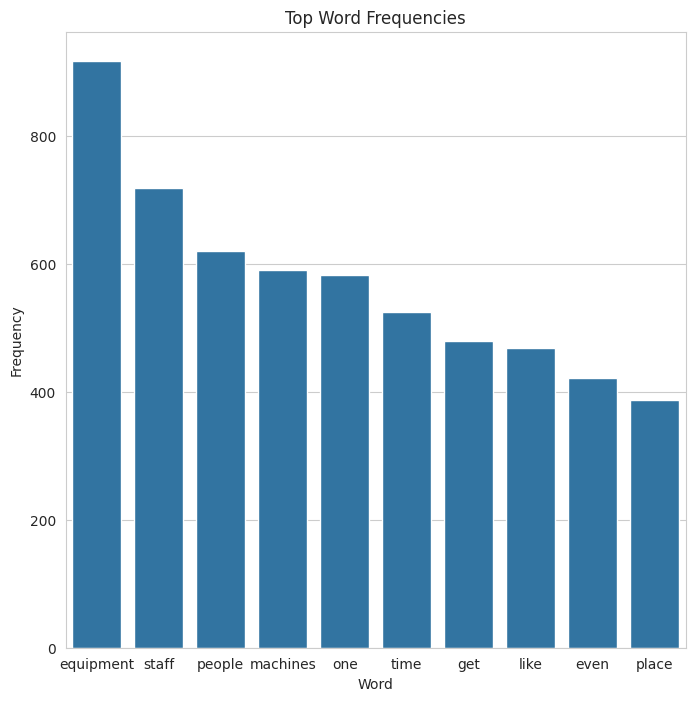

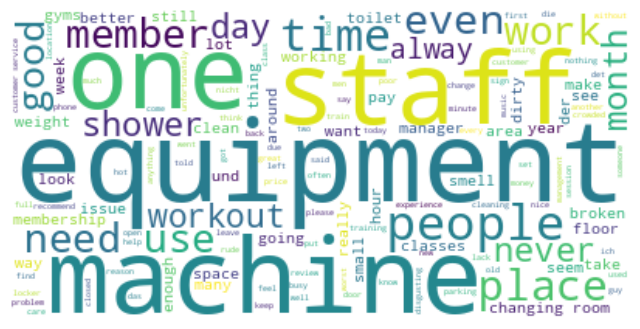

In [ ]:
bad_df_g = df_g[df_g["Score"] < 3]
word_cloud_code(df=bad_df_g, column_name='Tokenized_Comment', words_to_exclude=['gym', 'stargym', 'star', 'Star Gym']) ## Running by removing the word gym and star gym

**Trustpilot dataset**

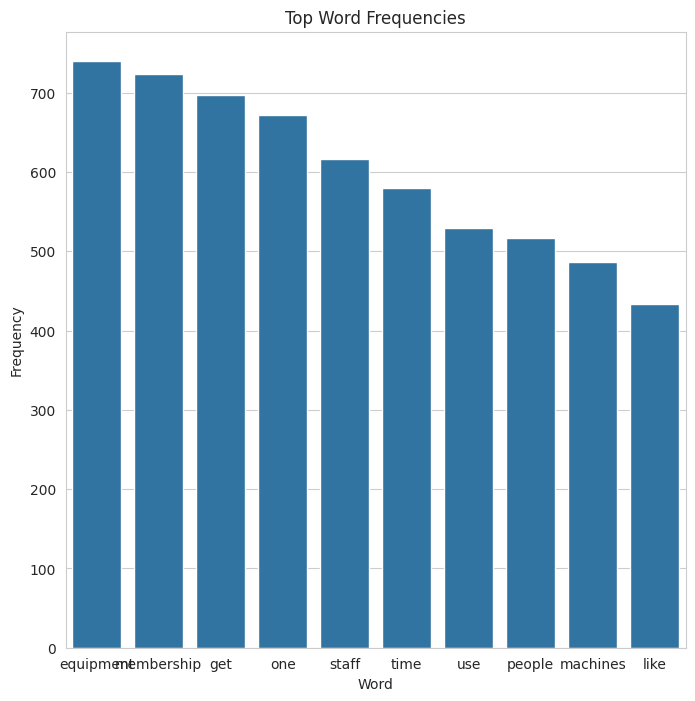

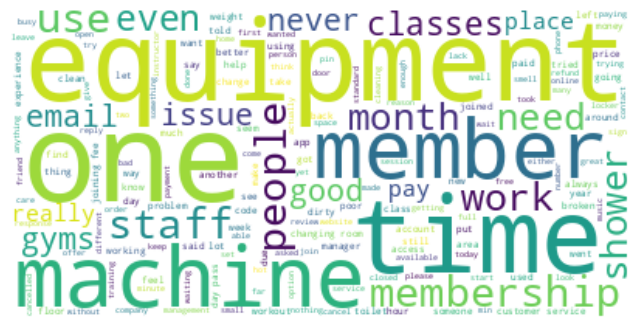

In [ ]:
bad_df_t = df_t[df_t["Score"] < 3]
word_cloud_code(df=bad_df_t, column_name='Tokenized_Comment', words_to_exclude=['gym', 'stargym', 'star', 'Star Gym']) ## Running by removing the word gym and star gym

🔍 The Word Cloud and frequency chart display the most mentioned terms, however it is difficult to truly understand the insights and the context around them, making the analysis difficult to for real actionable insights. Some limitations:

-	Differentiate between positive and negative contexts.

-	Group related terms or phrases (e.g., dirty equipment vs. great equipment).

-	Extract actionable topics or specific drivers behind customer feedback.

###**Filtering the reviews that are from the locations common to both data sets**

In [ ]:
bad_rff_google_df_both_locations = bad_df_g[bad_df_g['Location'].isin(intersection_of_locations)]

bad_df_g.loc[bad_df_g['Location'].isin(intersection_of_locations), "Comment"] = (
    bad_df_g.loc[bad_df_g['Location'].isin(intersection_of_locations), "Comment"].astype(str)
)
bad_google_reviews_list = bad_rff_google_df_both_locations["Comment"].tolist()

In [ ]:
bad_rff_trustpilot_df_both_locations = bad_df_t[bad_df_t['Location'].isin(intersection_of_locations)]

bad_df_t.loc[bad_df_t['Location'].isin(intersection_of_locations), "Comment"] = (
    bad_df_t.loc[bad_df_t['Location'].isin(intersection_of_locations), "Comment"].astype(str)
)
bad_trustpilot_reviews_list = bad_rff_trustpilot_df_both_locations["Comment"].tolist()

**Unifying the datasets**

In [ ]:
all_bad_reviews_list = bad_google_reviews_list + bad_trustpilot_reviews_list

In [ ]:
len(all_bad_reviews_list)

3950

In [ ]:
all_bad_reviews_list[1]

"(current member)\n\nGym is quite dirty, more often than not there's no soap in the bathroom. There is zero airflow in the gym, it's like a sauna in here. Also the gym is often overcrowded anytime after 3pm.\n\nThe only good thing about this gym is the  location and the bring your buddy thing"

🔍 There are 3,950 Google reviews and Trustpilot reviews available from the overlapping locations data. This list become the data for my modeling work.

**Data preprocessing for the unified dataset**

In [ ]:
all_bad_reviews_list_clean = []
for review in all_bad_reviews_list:
  #print(review)
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    all_bad_reviews_list_clean.append(review)

In [ ]:
print(all_bad_reviews_list_clean[1:10])

[' current member gym quite dirty often soap bathroom zero airflow gym like sauna also gym often overcrowded anytime pm good thing gym location bring buddy thing', 'this gym way hot even workout windows open ac barely works staff near friendly always rude especially men clients mean work ', 'no access wc empty assistance gain access fault forgot pin see stay enable assistance ', 'after gym year finally leaving gutted staff pts lovely stand overcrowded gym hours day lack equipment relation st james puregym going closing june even new upgrade eldon see going work gym already crowded think bit extra equipment help mention hot times year understand need heating gym supposed busting sweat becomes unbearable summer impossible complete workout lack aircon st james gym closing reason left ridiculously overcrowded', 'the gym huge equipment could easily fit double amount equipment expect usual grumpy pure gym goers facilities shame lack equipment potential actually half decent gym ', 'air condit

#**2) Conducting initial topic modelling**

💡 Provided some limitations from the Word Cloud, I progress now with more advanced modling technique to analyse the negative reviews and try to extract more context into customer feedbacks and insights for Star Gym. For this I apply BERTopic: the aim is to create a cluster of topics.

**Using BERTopic**

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=20, min_dist=0.1)

model2 = BERTopic(embedding_model=embedding_model, umap_model=umap_model, verbose=True)
model2.fit(all_bad_reviews_list_clean)
topic, probabilities = model2.transform(all_bad_reviews_list_clean)

**Interactive visualisation of the topics**

With this technique the topic clusters are visualised in a 2D space. By clicking on the different areas, it is possible to check topics relationships and distinctions.

In [ ]:
model2.visualize_topics()

**Barchart of the topics**

In [ ]:
import plotly.io as pio

fig = model2.visualize_barchart(top_n_topics=10, n_words=5)
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=50, r=50, t=100, b=50),
    font=dict(size=12),
    title=dict(
        text="Top 10 Topics and Their Key Words",
        font=dict(size=16),
        x=0.5,
        y=0.98,
        xanchor="center",
        yanchor="top"
    )
)

fig.show()

🔍 There is a clear distintion in key themes identified by topic analysis. These reveal insights into various aspects of customers experiences:

**Cleanliness & Hygiene (Topic 0)** – Concerns about dirty facilities, toilets, and changing rooms.

**Equipment & Maintenance (Topic 1, 3)**– Mentions of gym equipment, weight machines, and air conditioning.

**Classes & Bookings (Topic 4)** – Discussions around class availability, instructor quality, and cancellations.

**Parking & Access (Topic 5)** – Issues related to parking, fines, and car access.

**Showers & Facilities (Topic 6)** – Comments about water temperature, showers, and comfort.

**Customer Service (Topic 7)** – Complaints about rude staff, management, and member interactions.

**Membership & Support (Topic 8)** – Mentions of the gym app, joining process, and membership support.

**Noise Levels (Topic 9)** – Feedback about loud music, noise, and overall gym atmosphere.

#**3) Performing further data investigation**

💡 In this part I delve deeper into the negative reviews to gather more specific insights. For this I work on the top 20 locations by negative reviews volumes.

**List out the top 20 locations with the highest number of negative reviews**

In [ ]:
bad_df_g_filtered = bad_df_g[['Location', 'Score', 'Comment']]
top_20_locations_g = bad_df_g_filtered['Location'].value_counts().head(20)

In [ ]:
bad_df_t_filtered = bad_df_t[['Location', 'Score', 'Comment']]
top_20_locations_t = bad_df_t_filtered['Location'].value_counts().head(20)

**Merging the 2 data sets on Location data**

In this part I generate the final data selection for the deep-dive analysis. Here I include the total number of negative reviews for top locations (sum of Google reviews and Trustpilot reviews). The data is sorted based on the total number of reviews.

In [ ]:
# Merging the two datasets on the 'Location' column with an inner join
merged_locations = pd.merge(tot_badr_locations_g, tot_badr_locations_t, on='Location', how='inner')

print(merged_locations.head())

                        count_x  count_y
Location                                
London Stratford             59       22
London Canary Wharf          26        6
London Enfield               25       23
London Swiss Cottage         24       15
Birmingham City Centre       21       14


In [ ]:
merged_locations.columns = ['tot_badr_g', 'tot_badr_t']

# Adding a new column 'tot_badr' as the sum of 'tot_badr_g' and 'tot_badr_t' and sorting the total in descending order
merged_locations['tot_badr'] = merged_locations['tot_badr_g'] + merged_locations['tot_badr_t']
merged_locations_sorted = merged_locations.sort_values(by='tot_badr', ascending=False)

merged_locations_sorted.head(20)

,tot_badr_g,tot_badr_t,tot_badr
Location,,,
London Stratford,59,22,81
Leicester Walnut Street,11,50,61
London Enfield,25,23,48
London Swiss Cottage,24,15,39
Birmingham City Centre,21,14,35
London Bermondsey,16,18,34
London Seven Sisters,18,16,34
New Barnet,20,14,34
Bradford Thornbury,19,14,33


🔍 Most negative reviews are more likely to come from the London area.

**For the top 30 locations, I combine the reviews from Google and Trustpilot and run them through BERTopic**

In [ ]:
top_30_locations = merged_locations.sort_values(by='tot_badr', ascending=False).head(30)
filtered_comments_g = bad_df_g[bad_df_g['Location'].isin(top_30_locations.index)]
filtered_comments_t = bad_df_t[bad_df_t['Location'].isin(top_30_locations.index)]

In [ ]:
comments_g = filtered_comments_g[['Comment']]
comments_t = filtered_comments_t[['Comment']]
combined_comments = pd.concat([comments_g, comments_t], ignore_index=True)

print(combined_comments.head())
print(combined_comments.shape)

                                             Comment
0  This gym is way too hot to even workout in. Th...
1                       Air-conditioning doesnt work
2  Is pure gym staff allowed to blame or annoying...
3  Absolute filthy toilet and machines, some mach...
4  Overcrowded, full of teenagers who do not look...
(956, 1)


In [ ]:
filtered_bad_reviews_list_clean = []

for review in combined_comments['Comment']:
    if review is not None and review != "nan":
        review = review.lower()
        review = re.sub('[^A-Za-z]+', ' ', review)

        # Removing stopwords
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(review)
        filtered_review = ' '.join([w for w in word_tokens if w not in stop_words])

        filtered_bad_reviews_list_clean.append(filtered_review)

print(filtered_bad_reviews_list_clean[1])  # Printing the second cleaned review as an example

air conditioning doesnt work


**Using BERTopic**

In [ ]:
# Resetting the session.
def reset_session():
    tf.keras.backend.clear_session()
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

💡 I now add a few parameters to the model as I want to capture more granularity in the data for topics detection, the dataset is fairly small.

In [ ]:
reset_session()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=5, min_dist=0.7, metric='cosine')
vectorizer_model = CountVectorizer(max_df=0.5, min_df=3)
hdbscan_model = HDBSCAN(min_cluster_size=2, cluster_selection_epsilon=0.05, prediction_data=True)

In [ ]:
# Initialising the model
model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

# Fitting the model on the dataset
model.fit(filtered_bad_reviews_list_clean)
model.reduce_topics(filtered_bad_reviews_list_clean)

# Getting the topics and their probabilities
topics, probabilities = model.transform(filtered_bad_reviews_list_clean)

In [ ]:
fig = model.visualize_barchart(top_n_topics=10, n_words=5)
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=50, r=50, t=100, b=50),
    font=dict(size=12),
    title=dict(
        text="Top 10 Topics and Their Key Words",
        font=dict(size=16),
        x=0.5,
        y=0.98,
        xanchor="center",
        yanchor="top"
    )
)

fig.show()

🔍 The updated dataset of the top 30 shared locations (dominated by London) highlights new topics, including issues with showers, pin/pass access, lockers, overcrowding, and equipment problems, offering more geo-specific insights.

#**4) Conducting emotion analysis**

💡In this part of the work I want to understand what are the top emotions identified in the customers reviews. For this I use BERT Emotion model.

###**Apply BERT Emotion Model**

In [ ]:
emotion_classifier = pipeline(
    'text-classification',
    model='bhadresh-savani/bert-base-uncased-emotion',
    tokenizer='bhadresh-savani/bert-base-uncased-emotion',
    return_all_scores=True,
    truncation=True
)

**Example sentence**

Testing and visualising a sample result. the result on this random review return joy and suprise as the main detected emotions:

In [ ]:
test_prompt = df_t["Comment_new"].iloc[10]
emotion_labels = emotion_classifier(test_prompt, )
emotion_labels_sorted = sorted(emotion_labels[0], key=lambda x: x["score"], reverse=True)

print(test_prompt)
print(emotion_labels_sorted)

company really helpful accidentally applied membership replied quickly able give refund one memberships gym really good aswell overall great experience amazing customer service
[{'label': 'joy', 'score': 0.9882549047470093}, {'label': 'surprise', 'score': 0.009652316570281982}, {'label': 'anger', 'score': 0.0006365132867358625}, {'label': 'fear', 'score': 0.0005328762345016003}, {'label': 'love', 'score': 0.0004773406544700265}, {'label': 'sadness', 'score': 0.0004459754272829741}]


I now update the model pipeline to return only the top detected emotion per review:

In [ ]:
emotion_classifier = pipeline(
    'text-classification',
    model='bhadresh-savani/bert-base-uncased-emotion',
    tokenizer='bhadresh-savani/bert-base-uncased-emotion',
    return_all_scores=False,  # Updating this to returns first/ top emotion
    truncation=True
)

In [ ]:
def get_top_emotion(text):
     text = str(text)
    results = emotion_classifier(text)
    top_emotion = results[0]['label']
    return top_emotion

**Google Data**

In [ ]:
# Applyng the function to each review in the DataFrame's "Comment_new" column,
df_g['Top Emotion'] = df_g['Comment_new'].apply(get_top_emotion)

print(df_g[['Comment_new', 'Top Emotion']].head())

                                         Comment_new Top Emotion
0  many students two local colleges go leave rubb...       anger
1  best range equipment cheaper regular gyms prof...         joy
2  good gym busy tend get busy late afternoon har...         joy
3  current member gym quite dirty often soap bath...     sadness
4  kom og betalte en pr vetime centret fik blot e...       anger


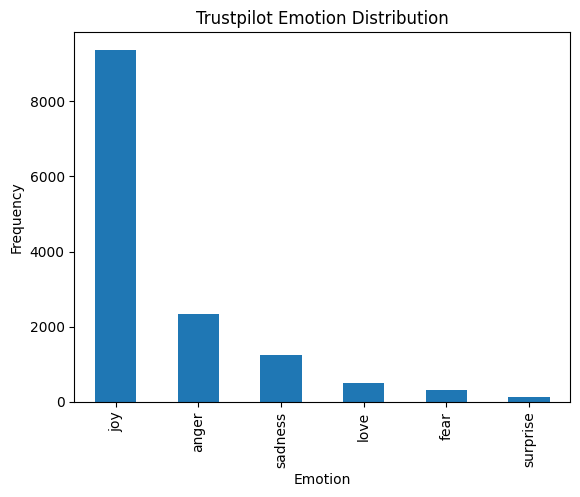

In [ ]:
df_g['Top Emotion'].value_counts().plot(kind='bar', title='Trustpilot Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

Overall emotions detected in Google reviews is joy. However if I delve into the negative reviews cohort (below), anger becomes the most prominent feeling amongst customers who provided a negative review, followed by sadness.

**Barplot on negative reviews**

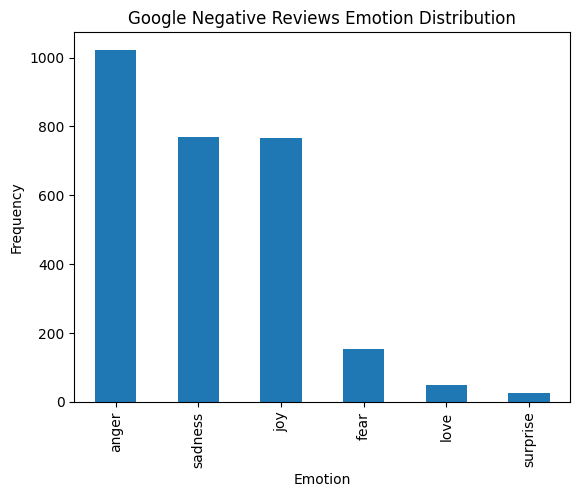

In [ ]:
filtered_df_g = df_g[df_g['Score'] < 3]

filtered_df_g['Top Emotion'].value_counts().plot(kind='bar', title='Google Negative Reviews Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

**Sense checking predicted classification accuracy**

Assigning Score < 3 as target (negative feedback) and Top emotions (anger, fear, sadness) as predicted negative emotions.

In [ ]:
# Creating a new DataFrame with selected columns
df_target_predicted = df_g_new[['Score', 'Top Emotion']].copy()

# Adding a 'target' column: True if Score < 3, else False and also the 'predicted' emotions column. Here I chose negative sentiments ['anger', 'fear', 'sadness']
df_target_predicted['target'] = df_target_predicted['Score'] < 3
df_target_predicted['predicted'] = df_target_predicted['Top Emotion'].isin(['anger', 'fear', 'sadness'])

print(df_target_predicted.head())

   Score Top Emotion  target  predicted
0      1       anger    True       True
1      5         joy   False      False
2      4         joy   False      False
3      1     sadness    True       True
4      1       anger    True       True


Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.82      0.87     11113
        True       0.50      0.70      0.58      2785

    accuracy                           0.80     13898
   macro avg       0.71      0.76      0.73     13898
weighted avg       0.83      0.80      0.81     13898



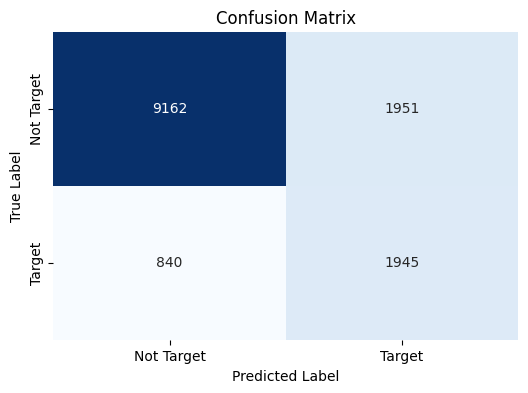

Accuracy: 79.92%
F1 Score: 58.22%
Precision: 49.92%
Recall: 69.84%


In [ ]:
# Calculating performance metrics
accuracy = accuracy_score(df_target_predicted['target'], df_target_predicted['predicted'])
precision = precision_score(df_target_predicted['target'], df_target_predicted['predicted'], average='binary', pos_label=True)
recall = recall_score(df_target_predicted['target'], df_target_predicted['predicted'], average='binary', pos_label=True)
f1 = f1_score(df_target_predicted['target'], df_target_predicted['predicted'], average='binary', pos_label=True)

report = classification_report(df_target_predicted['target'], df_target_predicted['predicted'])
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(df_target_predicted['target'], df_target_predicted['predicted'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Not Target", "Target"], yticklabels=["Not Target", "Target"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

🔍 Based on a proxy estimate, the model applied to Google data achieves an overall accuracy of 79.9% in classifying negative reviews.

**Trustpilot Data**

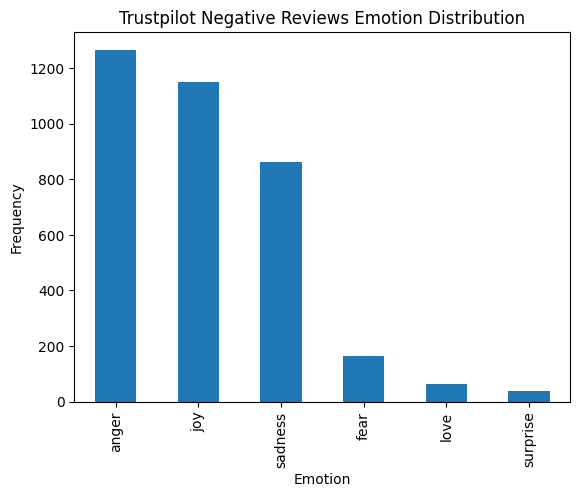

In [ ]:
filtered_df_t = df_t[df_t['Score'] < 3]  # Filter rows where 'Score' is less than 3

filtered_df_t['Top Emotion'].value_counts().plot(kind='bar', title='Trustpilot Negative Reviews Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

There seems to be an over-representation of "joy" amongst the negative reviews collected on Trustpilot data.

In [ ]:
df_target_t_predicted = df_t[['Score', 'Top Emotion']].copy()
df_target_t_predicted['target'] = df_target_t_predicted['Score'] < 3
df_target_t_predicted['predicted'] = df_target_t_predicted['Top Emotion'].isin(['anger', 'fear', 'sadness'])
print(df_target_t_predicted.head())

   Score Top Emotion  target  predicted
0      5         joy   False      False
1      5         joy   False      False
2      1         joy    True      False
3      5         joy   False      False
4      5         joy   False      False


Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.86      0.88     13130
        True       0.55      0.65      0.59      3543

    accuracy                           0.81     16673
   macro avg       0.72      0.75      0.74     16673
weighted avg       0.83      0.81      0.82     16673



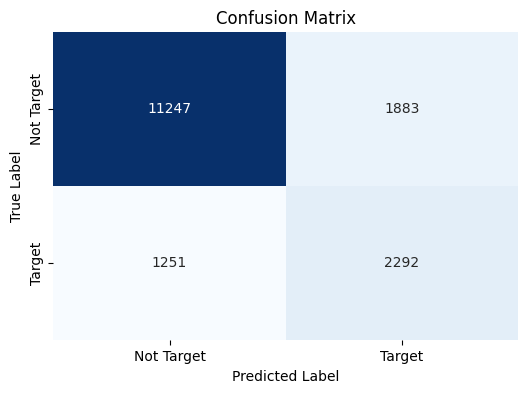

Accuracy: 81.20%
F1 Score: 59.39%
Precision: 54.90%
Recall: 64.69%


In [ ]:
accuracy = accuracy_score(df_target_t_predicted['target'], df_target_t_predicted['predicted'])
precision = precision_score(df_target_t_predicted['target'], df_target_t_predicted['predicted'], average='binary', pos_label=True)
recall = recall_score(df_target_t_predicted['target'], df_target_t_predicted['predicted'], average='binary', pos_label=True)
f1 = f1_score(df_target_t_predicted['target'], df_target_t_predicted['predicted'], average='binary', pos_label=True)

report = classification_report(df_target_t_predicted['target'], df_target_t_predicted['predicted'])
print("Classification Report:\n", report)
conf_matrix = confusion_matrix(df_target_t_predicted['target'], df_target_t_predicted['predicted'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Not Target", "Target"], yticklabels=["Not Target", "Target"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Based on a proxy estimate, the model applied to Trustpilot data achieves an overall accuracy of 81.2% in classifying negative reviews.

**Extracting all the negative reviews where anger is top emotion**

💡 I now work on the reviews where anger is the top identified emotions to re-assess the topics that emerge in this group of customers and gather relevant insights for Star Gym.

In [ ]:
df_g['Comment_new'] = df_g['Comment_new'].astype(str)
df_t['Comment_new'] = df_t['Comment_new'].astype(str)

filtered_df_g = df_g[
    (df_g['Score'] < 3) &
    (df_g['Top Emotion'] == 'anger') &
    (df_g['Location'].isin(intersection_of_locations))  ### filtering on shared locations for consistency with previous analysis
]['Comment_new']

filtered_df_t = df_t[
    (df_t['Score'] < 3) &
    (df_t['Top Emotion'] == 'anger') &
    (df_t['Location'].isin(intersection_of_locations))  ### filtering on shared locations for consistency with previous analysis
]['Comment_new']

In [ ]:
filtered_df_all = pd.concat([filtered_df_g, filtered_df_t], ignore_index=True)
filtered_df_all = filtered_df_all.str.replace(r'\bnah\b', '', regex=True, case=False)
print(filtered_df_all.shape)
print(filtered_df_all.head())

(1328,)
0    many students two local colleges go leave rubb...
1    gym way hot even workout windows open ac barel...
2    gym huge equipment could easily fit double amo...
3                         air conditioning doesnt work
4    friend new gym joined struggling get scanner w...
Name: Comment_new, dtype: object


**Run BERTopic on the output of the previous step**

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=5, min_dist=0.8, metric='cosine')
vectorizer_model = CountVectorizer(max_df=0.7, min_df=2)

hdbscan_model = HDBSCAN(min_cluster_size=2, cluster_selection_epsilon=0.05, prediction_data=True)

model_new = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

model_new.fit(filtered_df_all)
model_new.reduce_topics(filtered_df_all)
topics, probabilities = model_new.transform(filtered_df_all)

In [ ]:
model_new.visualize_topics()

In [ ]:
fig = model_new.visualize_barchart(top_n_topics=10, n_words=5)
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=50, r=50, t=100, b=50),
    font=dict(size=12),
    title=dict(
        text="Top 10 Topics and Their Key Words",
        font=dict(size=16),
        x=0.5,
        y=0.98,
        xanchor="center",
        yanchor="top"
    )
)

fig.show()

🔍 Keywords like "rude", "manager", "staff", "unprofessional" indicate complaints about customer service, particularly involving staff behaviour or management. The keywords "rubbish", "absolute", "waste", and "recommend" suggest that customers may be expressing dissatisfaction with the overall experience.

#**5) Using a large language model from Hugging Face**

💡In this part of the work I want to delve deeper into the insights gathered on negative reviews and I use a Large Language Model from Hugging Face: *Phi-3.5-mini-instruct*.

**Using merged datasets on locations (negative reviews only)**

In [ ]:
bad_trustpilot_reviews = bad_df_t.loc[bad_df_t['Location'].isin(intersection_of_locations)]
bad_google_reviews = bad_df_g.loc[bad_df_g['Location'].isin(intersection_of_locations)]
merged_bad_reviews = pd.concat([bad_trustpilot_reviews, bad_google_reviews], ignore_index=True)

In [ ]:
# Converting bad reviews to list
merged_bad_reviews_list = merged_bad_reviews["Comment"].to_list()

In [ ]:
bad_reviews_list_clean = []
for review in merged_bad_reviews_list:
  if review is not None:
    bad_reviews_list_clean.append(review)

In [ ]:
len(bad_reviews_list_clean)

3950

###**Using microsoft/Phi-3.5-mini-instruct**

In [ ]:
torch.random.manual_seed(0)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
generation_args = {
    "max_new_tokens": 1000,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

Due to computational power limits, I chose to test the model on a 200 reviews sample.

In [ ]:
all_topics = []

# Limiting the number of reviews to 200 or the length of the list, whichever is smaller
num_reviews = min(200, len(bad_reviews_list_clean))

for review in bad_reviews_list_clean[:num_reviews]:
    if len(str(review)) < 1000:
        messages_1 = [
    {
        "role": "user",
        "content": (
            "Below is a customer review. Please identify the top 3 main topics related to customer experience, focusing on issues, complaints, or suggestions. "
            "Return the topics in a numbered list format, with each topic on a separate line, like this:\n"
            "1. [Topic 1]\n"
            "2. [Topic 2]\n"
            "3. [Topic 3]"
        )
    },
    {
        "role": "assistant",
        "content": review
    }
]

        output = pipe(messages_1, **generation_args)

        topic_list_string = output[0]['generated_text']

        try:
            topic_list = json.loads(topic_list_string)
        except json.JSONDecodeError:
            topic_list = [
                line.strip() for line in topic_list_string.split("\n")
                if line.strip()
            ]

        all_topics.append(topic_list[:3])  # Only keep the first 3 topics if there are more

np_all_topics = np.array(all_topics, dtype=object)
np.save('np_all_topics_new.npy', np_all_topics)

print(np_all_topics[:5])  # Displaying the first 5 sets of topics as a preview

[list(['1. Overcrowding and lack of ventilation', '2. Poor air quality', '3. Insufficient seating capacity or waiting area'])
 list(['1. Poor hygiene and cleanliness in changing rooms', '2. Inadequate smell management in toilets', '3. Insufficient regular cleaning and maintenance of facilities'])
 list(['1. Lack of cleanliness and maintenance', '2. Poor equipment usage and safety', '3. Insufficient staffing and supervision'])
 list(['1. Poor Customer Service', '2. Inadequate Access to Gym Facilities', '3. Lack of Efficient Transaction Process (Receipt and Access Code Issues)'])
 list(['£££££££.', '1. Lack of rules and regulations: The customer is unhappy with the lack of clear rules and guidelines, particularly regarding the use of equipment and the use of phones.', '2. Uncomfortable gym environment: The customer describes the gym atmosphere as "scary," indicating dissatisfaction with the overall environment and possibly the behavior of other members.'])]


In [ ]:
topics_llm = np_all_topics.tolist()

In [ ]:
print(topics_llm)

[['1. Overcrowding and lack of ventilation', '2. Poor air quality', '3. Insufficient seating capacity or waiting area'], ['1. Poor hygiene and cleanliness in changing rooms', '2. Inadequate smell management in toilets', '3. Insufficient regular cleaning and maintenance of facilities'], ['1. Lack of cleanliness and maintenance', '2. Poor equipment usage and safety', '3. Insufficient staffing and supervision'], ['1. Poor Customer Service', '2. Inadequate Access to Gym Facilities', '3. Lack of Efficient Transaction Process (Receipt and Access Code Issues)'], ['£££££££.', '1. Lack of rules and regulations: The customer is unhappy with the lack of clear rules and guidelines, particularly regarding the use of equipment and the use of phones.', '2. Uncomfortable gym environment: The customer describes the gym atmosphere as "scary," indicating dissatisfaction with the overall environment and possibly the behavior of other members.'], ['1. Lack of immediate assistance', '2. Inadequate staff ava

The model successfully extracted and listed key topics and insights from the negative reviews data.

###**Run BERTopic on the above listed topics**

💡 I now re-run BERT topic on the topics extracted by the LLM model to identify new themes that were not necessarily detected by previous models. The combination of LLM and BERTopic will allow a more specific view of customers' concerns.

**Preprocessing the output data generated by the LLM**

In [ ]:
filtered_topics_new = []

terms_to_filter = ["gym", "gyms", "stargym", "Stargym"]

for topic_list in topics_llm:
    filtered_list = []
    for topic in topic_list:
        if isinstance(topic, str):
            # Removing numbering (e.g., "1. ", "2. ", etc.)
            cleaned_topic = re.sub(r"^\d+\.\s*", "", topic)
            # Removing special characters and symbols, keeping only alphanumeric and basic punctuation
            cleaned_topic = re.sub(r"[^a-zA-Z0-9\s,]", "", cleaned_topic)
            # Removing extra whitespace
            cleaned_topic = re.sub(r"\s+", " ", cleaned_topic).strip()

            for term in terms_to_filter:
                cleaned_topic = re.sub(rf"\b{term}\b", "", cleaned_topic, flags=re.IGNORECASE)

            filtered_list.append(cleaned_topic)

    filtered_topics_new.extend(filtered_list)

print(filtered_topics_new)

['Overcrowding and lack of ventilation', 'Poor air quality', 'Insufficient seating capacity or waiting area', 'Poor hygiene and cleanliness in changing rooms', 'Inadequate smell management in toilets', 'Insufficient regular cleaning and maintenance of facilities', 'Lack of cleanliness and maintenance', 'Poor equipment usage and safety', 'Insufficient staffing and supervision', 'Poor Customer Service', 'Inadequate Access to  Facilities', 'Lack of Efficient Transaction Process Receipt and Access Code Issues', '', 'Lack of rules and regulations The customer is unhappy with the lack of clear rules and guidelines, particularly regarding the use of equipment and the use of phones', 'Uncomfortable  environment The customer describes the  atmosphere as scary, indicating dissatisfaction with the overall environment and possibly the behavior of other members', 'Lack of immediate assistance', 'Inadequate staff availability', 'Poor communication and followup procedures', 'and the  is a free for al

In [ ]:
# Removing duplicates and cleaning topics
cleaned_topics_list = list(set([topic.strip().lower() for topic in filtered_topics_new if topic != "No topics identified"]))

In [ ]:
print(cleaned_topics_list)

['', 'inefficient customer service response to reported issues', 'lack of available staff', 'poor sanitation and hygiene in the  toilets', 'technical glitches in the system', 'delayed or missed class start', 'poor customer service and overall experience', 'inadequate water temperature', 'accessibility issues for new immigrants', 'difficulty in using the free day pass', 'payment and refund issues', 'we are a family business and we have to make a living we have to cover our costs and make a profit we are not a charity we have to pay for our staff, rent, utilities, equipment, and other expenses the prices are competitive with other  in the area, and we offer a range of services and classes that justify the cost we also have a loyal customer base that appreciates our quality and value i apologize if our prices seem high, but we believe they are fair and reasonable i hope you will reconsider your decision and give us a chance to prove our worth thank you for your feedback and understanding'

In [ ]:
# running BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

umap_model = UMAP(n_neighbors=15, min_dist=0.05, n_components=5)

model5 = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    verbose=True,
    min_topic_size=5
)

model5.fit(cleaned_topics_list)

topic, probabilities = model5.transform(cleaned_topics_list)

topic_info = model5.get_topic_info()
print(topic_info)

for topic_id in range(min(5, len(topic_info))):
    print(f"Topic {topic_id}: {model5.get_topic(topic_id)}")

In [ ]:
fig = model5.visualize_barchart(top_n_topics=10, n_words=5)
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=50, r=50, t=100, b=50),
    font=dict(size=12),
    title=dict(
        text="Top 10 Topics and Their Key Words",
        font=dict(size=16),
        x=0.5,
        y=0.98,
        xanchor="center",
        yanchor="top"
    )
)

fig.show()

🔍 The insights have now added new, more granular, information with details around compliants topics on pricing, slow customer service response times, billing and payment refund issues, issues with website signup process, poor customer service overall, lack of staff supervision.

###**Running LLM model to generate insights**

💡 Here I use the output generated by the LLM to further delve into the outputs by interrogating the LLM with new prompts that generate insights and recommendations for Star Gym around areas of improvement for customer satisfaction.

In [ ]:
# Flatten and clean the topics into one list
cleaned_topics_flat = list(set([
    re.sub(r"[^a-zA-Z0-9\s]", "", re.sub(r"^\d+\.\s*", "", str(topic))).strip()
    for topic_list in topics_llm
    for topic in topic_list
    if isinstance(topic, str)
]))

I simplify text by reducing length of comments to help run the model:

In [ ]:
def shorten_text(text, max_words=50):
    words = text.split()
    # If the text contains more than 'max_words' words, I truncate it
    if len(words) > max_words:
        text = ' '.join(words[:max_words]) + "..."
    return text
shortened_topics = [shorten_text(topic) for topic in cleaned_topics_flat]

In [ ]:
batch_size = 1  # Process one review at a time

# Collect all actionable insights
all_actionable_insights = []

for i in range(0, len(cleaned_topics_flat), batch_size):
    batch = cleaned_topics_flat[i:i + batch_size]
    batch_text = "\n".join(batch)

    # Create the full prompt inside the loop
    full_prompt = (
        f"In the following list containing the main extracted topics from customer negative reviews, "
        "group or compress the topics and return them with actionable insights that could help this gym company "
        "in a numbered list:\n\n" + batch_text
    )

    # Input for the model
    messages = [
        {"role": "user", "content": full_prompt}
    ]

    # Generating actionable insights using the pipeline
    output = pipe(messages, **generation_args)

    actionable_insights = output[0]['generated_text']
    all_actionable_insights.append(actionable_insights)

    print(actionable_insights)

# Display all actionable insights
for insights in all_actionable_insights:
    print(insights)

 1. **Fitness Equipment Quality and Maintenance**
   - Actionable Insight: Implement a regular maintenance schedule for all gym equipment to ensure they are in optimal condition. Invest in high-quality, durable equipment to reduce the frequency of repairs and replacements.

2. **Staff Training and Customer Service**
   - Actionable Insight: Provide comprehensive training programs for staff focusing on customer service excellence. Encourage a culture of empathy and responsiveness to customer needs.

3. **Cleanliness and Sanitation**
   - Actionable Insight: Increase the frequency of cleaning, especially during peak hours. Clearly communicate cleaning schedules to members and ensure proper sanitation protocols are followed.

4. **Membership Pricing and Value**
   - Actionable Insight: Review the pricing structure to ensure it aligns with the value provided. Consider offering tiered membership options or discounts for long-term commitments to enhance perceived value.

5. **Facility Layout

#**6) Using Gensim for topic modeling**
###**Apply LDA Model**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

In [ ]:
# Loading the list of negative reviews
merged_bad_reviews_list = merged_bad_reviews["Comment"].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Defining stop words and punctuation.
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Function to clean the document.
def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Words to filter out
filter_words = ["gym", "gyms", "stargym", "star gym", "Star", "Star gym"]

# Remove filter words from comments
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in filter_words) + r')\b'
merged_bad_reviews["Filtered_Comment"] = merged_bad_reviews["Comment"].apply(
    lambda c: re.sub(pattern, '', c, flags=re.IGNORECASE) if isinstance(c, str) else c
)

In [ ]:
documents = merged_bad_reviews["Filtered_Comment"]

In [ ]:
documents = [clean(doc) for doc in  documents]

**Tokenize the document**

In [ ]:
tokenized_docs = [doc.lower().split() for doc in documents]

**Create a dictionary and a corpus**

In [ ]:
dictionary = corpora.Dictionary(tokenized_docs)

# Filter out words that occur fewer than 2 documents
dictionary.filter_extremes(no_below=3, no_above=0.8)

### Building the LDA model using the dictionary and corpus

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [ ]:
# Setting parameters.
num_topics = 10
passes = 30

# Create the LDA model.
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

In [ ]:
# Print the topics.
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))

Topic: 0 
Words: 0.024*"membership" + 0.021*"price" + 0.021*"fee" + 0.021*"wifi" + 0.016*"get" + 0.015*"day" + 0.014*"code" + 0.014*"month" + 0.013*"joining" + 0.009*"pay"
Topic: 1 
Words: 0.017*"time" + 0.012*"machine" + 0.012*"one" + 0.011*"month" + 0.009*"get" + 0.009*"it’s" + 0.008*"don’t" + 0.008*"staff" + 0.007*"week" + 0.006*"minute"
Topic: 2 
Words: 0.024*"membership" + 0.015*"one" + 0.012*"people" + 0.012*"weight" + 0.008*"cancel" + 0.008*"like" + 0.008*"get" + 0.007*"even" + 0.007*"use" + 0.007*"back"
Topic: 3 
Words: 0.030*"staff" + 0.024*"member" + 0.023*"manager" + 0.014*"rude" + 0.014*"customer" + 0.011*"service" + 0.011*"help" + 0.011*"email" + 0.010*"pt" + 0.009*"said"
Topic: 4 
Words: 0.031*"equipment" + 0.024*"machine" + 0.015*"people" + 0.013*"weight" + 0.011*"time" + 0.010*"place" + 0.010*"staff" + 0.009*"use" + 0.009*"one" + 0.007*"need"
Topic: 5 
Words: 0.023*"closed" + 0.014*"time" + 0.013*"open" + 0.013*"day" + 0.011*"email" + 0.010*"hour" + 0.010*"use" + 0.009*

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


💡 The topics are fairly consistent with those generated from previous models**, e.g. keywords like
“membership”, “price”, “fee”, “code” have a higher probability to define the first topic, in line with
concerns already identified around membership and joining costs.  
An Intertopic Distance Map shows topic relationships, while a Relevance Chart highlights key terms for
each topic, aiding result interpretation:

In [ ]:
# Visualisation.
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Terms like "membership," "price," and "fee" dominate the relevance chart for Topic 10. Adjusting the
relevance metric λ (which balances term frequency within a topic and its exclusivity across topics)
highlights more specific, granular insights, bringing new terms to the forefront:

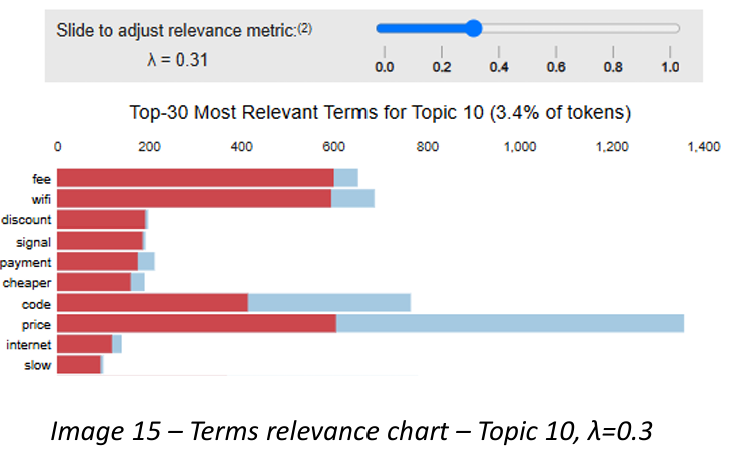

These terms suggest that the topic centres on issues related to costs (e.g. 'fee,' 'discount,' 'price') and
internet access (e.g. 'Wi-Fi,' 'signal,' 'internet'), focusing on complaints about pricing and perceived on
premises services quality.

### **Insights summary**

Insights from BERTopic, LLM, and LDA models consistently highlight issues such as membership pricing and value, website navigation and functionality, staff professionalism, cleanliness and health measures, equipment upkeep, class scheduling, overcrowding, and parking.  

Recommendations include reviewing pricing strategies, improving online platforms, providing staff training, increasing health and safety measures, maintaining equipment, optimising class availability, and addressing space and parking constraints to enhance overall member satisfaction.